# Libraries

In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Class for Filters/Techniques

Processing image 1/700 (class 0)...
 HSV mask foreground pixels: 130815
 After opening: 127755, After connected-component filtering: 121125
 After filling holes: 121125
{'corner_count': 5553, 'circularity': 0.13930374202013132, 'aspect_ratio': 1.1388888888888888, 'extent': 0.3218157181571816, 'avg_hue': 21.752377321060976}
Processing image 2/700 (class 0)...
 HSV mask foreground pixels: 20145
 After opening: 9690, After connected-component filtering: 0
 After filling holes: 0
{'corner_count': 1321, 'circularity': 0.0, 'aspect_ratio': 1.0, 'extent': 0.0, 'avg_hue': 0.0}
Processing image 3/700 (class 0)...
 HSV mask foreground pixels: 81345
 After opening: 55335, After connected-component filtering: 50745
 After filling holes: 50745
{'corner_count': 4115, 'circularity': 0.1958420982267582, 'aspect_ratio': 0.8571428571428571, 'extent': 0.2961309523809524, 'avg_hue': 10.567092886763021}
Processing image 4/700 (class 0)...
 HSV mask foreground pixels: 428655
 After opening: 427635, After co

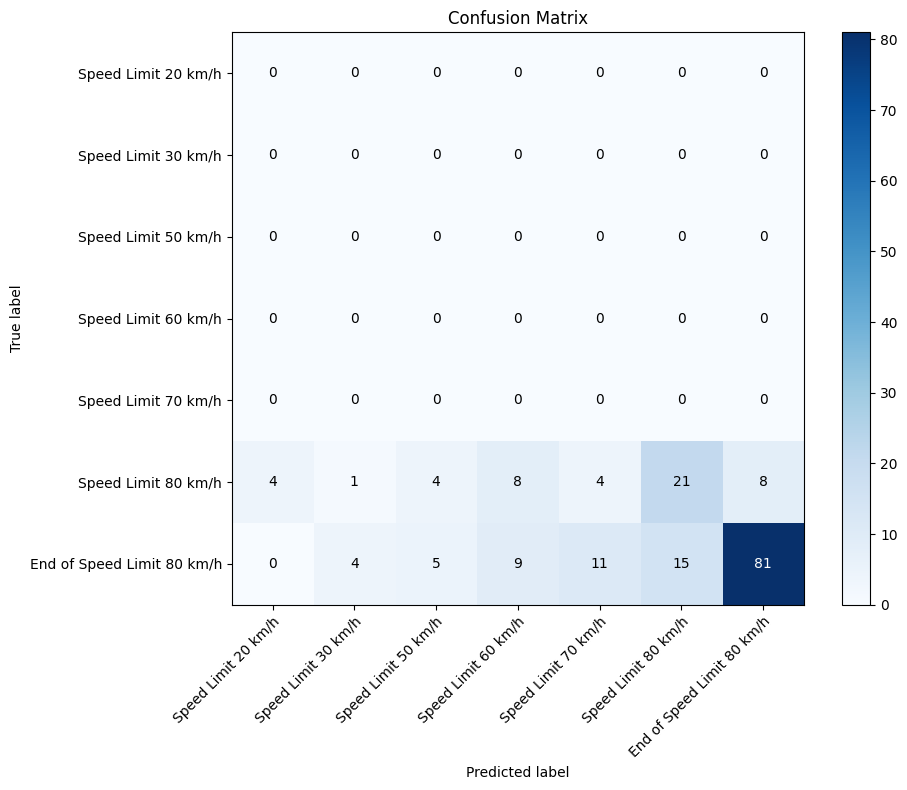

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 4,  1,  4,  8,  4, 21,  8],
       [ 0,  4,  5,  9, 11, 15, 81]])

In [ ]:
class TrafficSignClassifier:
    def __init__(self):
        # Store preprocessed images, features, etc.
        self.processed_images = {}
        self.features = {}
        self.labels = {}
        self.class_names = {
            0: "Speed Limit 20 km/h",
            1: "Speed Limit 30 km/h",
            2: "Speed Limit 50 km/h",
            3: "Speed Limit 60 km/h",
            4: "Speed Limit 70 km/h",
            5: "Speed Limit 80 km/h",
            6: "End of Speed Limit 80 km/h"
        }
    
    # ==================== PREPROCESSING FILTERS ====================
    
    def mean_filter(self, image, kernel_size=3):
        """Apply mean filter using NumPy operations."""
        if len(image.shape) == 3:  # Color image
            height, width, channels = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
            
            # Apply filter
            for c in range(channels):
                for i in range(height):
                    for j in range(width):
                        window = padded[i:i+kernel_size, j:j+kernel_size, c]
                        result[i, j, c] = np.mean(window)
                        
        else:  # Grayscale image
            height, width = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
            
            # Apply filter
            for i in range(height):
                for j in range(width):
                    window = padded[i:i+kernel_size, j:j+kernel_size]
                    result[i, j] = np.mean(window)
                    
        return result
    
    def gaussian_filter(self, image, kernel_size=3, sigma=1.0):
        """Apply Gaussian filter using NumPy operations."""
        # Create Gaussian kernel
        k = kernel_size // 2
        x, y = np.mgrid[-k:k+1, -k:k+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        kernel = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
        kernel = kernel / np.sum(kernel)  # Normalize
        
        if len(image.shape) == 3:  # Color image
            height, width, channels = image.shape
            result = np.zeros_like(image, dtype=np.float32)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
            
            # Apply filter
            for c in range(channels):
                for i in range(height):
                    for j in range(width):
                        window = padded[i:i+kernel_size, j:j+kernel_size, c]
                        result[i, j, c] = np.sum(window * kernel)
                        
        else:  # Grayscale image
            height, width = image.shape
            result = np.zeros_like(image, dtype=np.float32)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
            
            # Apply filter
            for i in range(height):
                for j in range(width):
                    window = padded[i:i+kernel_size, j:j+kernel_size]
                    result[i, j] = np.sum(window * kernel)
        
        return np.clip(result, 0, 255).astype(np.uint8)
    
    def median_filter(self, image, kernel_size=3):
        """Apply median filter using NumPy operations."""
        if len(image.shape) == 3:  # Color image
            height, width, channels = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
            
            # Apply filter
            for c in range(channels):
                for i in range(height):
                    for j in range(width):
                        window = padded[i:i+kernel_size, j:j+kernel_size, c]
                        result[i, j, c] = np.median(window)
                        
        else:  # Grayscale image
            height, width = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            pad_size = kernel_size // 2
            
            # Pad the image
            padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
            
            # Apply filter
            for i in range(height):
                for j in range(width):
                    window = padded[i:i+kernel_size, j:j+kernel_size]
                    result[i, j] = np.median(window)
                    
        return result
    
    def adaptive_median_filter(self, image, max_kernel_size=7):
        """Apply adaptive median filter using NumPy operations."""
        if len(image.shape) == 3:  # Color image
            height, width, channels = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            
            for c in range(channels):
                for i in range(height):
                    for j in range(width):
                        pixel_value = self._adaptive_median_process(image[:,:,c], i, j, max_kernel_size)
                        result[i, j, c] = pixel_value
                        
        else:  # Grayscale image
            height, width = image.shape
            result = np.zeros_like(image, dtype=np.uint8)
            
            for i in range(height):
                for j in range(width):
                    result[i, j] = self._adaptive_median_process(image, i, j, max_kernel_size)
                    
        return result
    
    def _adaptive_median_process(self, image, i, j, max_size):
        """Helper function for adaptive median filter."""
        kernel_size = 3  # Start with 3x3 window
        
        while kernel_size <= max_size:
            pad_size = kernel_size // 2
            h, w = image.shape
            
            # Ensure we don't go out of bounds
            i_min = max(0, i - pad_size)
            i_max = min(h, i + pad_size + 1)
            j_min = max(0, j - pad_size)
            j_max = min(w, j + pad_size + 1)
            
            window = image[i_min:i_max, j_min:j_max]
            window_flat = window.flatten()
            
            z_min = np.min(window_flat)
            z_max = np.max(window_flat)
            z_med = np.median(window_flat)
            z_xy = image[i, j]
            
            # Stage A
            if z_med > z_min and z_med < z_max:
                # Stage B
                if z_xy > z_min and z_xy < z_max:
                    return z_xy
                else:
                    return z_med
            else:
                # Increase kernel size and try again
                kernel_size += 2
                if kernel_size > max_size:
                    return z_med
    
    def unsharp_masking(self, image, kernel_size=5, alpha=1.5):
        """Apply unsharp masking for edge enhancement."""
        # Apply Gaussian filter to create blurred image
        blurred = self.gaussian_filter(image, kernel_size=kernel_size, sigma=1.0)
        
        # Calculate the mask (original - blurred)
        if len(image.shape) == 3:
            mask = image.astype(np.float32) - blurred.astype(np.float32)
            # Apply high-boost filtering (original + alpha * mask)
            sharpened = image.astype(np.float32) + alpha * mask
        else:
            mask = image.astype(np.float32) - blurred.astype(np.float32)
            sharpened = image.astype(np.float32) + alpha * mask
            
        # Clip values to valid range
        return np.clip(sharpened, 0, 255).astype(np.uint8)
    
    # ==================== COLOR SPACE CONVERSION ====================
    
    def rgb_to_hsv(self, rgb_img):
        """
        Convert RGB image to HSV color space manually using NumPy operations.
        Input: RGB image with values in range [0, 255]
        Output: HSV image with H in [0, 180), S in [0, 255], V in [0, 255]
        """
        # Normalize RGB values to [0, 1]
        rgb_normalized = rgb_img.astype(np.float32) / 255.0
        
        r, g, b = rgb_normalized[:,:,0], rgb_normalized[:,:,1], rgb_normalized[:,:,2]
        
        # Value (V) is the maximum of R, G, B
        v = np.max(rgb_normalized, axis=2)
        
        # Calculate delta (difference between max and min RGB values)
        min_rgb = np.min(rgb_normalized, axis=2)
        delta = v - min_rgb
        
        # Initialize HSV arrays
        h = np.zeros_like(r)
        s = np.zeros_like(r)
        
        # Calculate Saturation (S)
        # If V is 0, S is also 0
        s = np.where(v != 0, delta / np.maximum(v, 1e-10), 0)
        
        # Calculate Hue (H)
        # If delta is 0, H is undefined (we'll set it to 0)
        # Otherwise, calculate based on which channel is max
        
        # For pixels where R is max
        r_max_mask = (v == r) & (delta != 0)
        h[r_max_mask] = 60 * (((g[r_max_mask] - b[r_max_mask]) / delta[r_max_mask]) % 6)
        
        # For pixels where G is max
        g_max_mask = (v == g) & (delta != 0)
        h[g_max_mask] = 60 * (((b[g_max_mask] - r[g_max_mask]) / delta[g_max_mask]) + 2)
        
        # For pixels where B is max
        b_max_mask = (v == b) & (delta != 0)
        h[b_max_mask] = 60 * (((r[b_max_mask] - g[b_max_mask]) / delta[b_max_mask]) + 4)
        
        # Ensure H is in [0, 180) range for OpenCV compatibility
        h = h / 2.0
        
        # Scale S and V to [0, 255]
        s = s * 255.0
        v = v * 255.0
        
        # Stack channels and convert to uint8
        hsv_img = np.stack([h, s, v], axis=2).astype(np.uint8)
        
        return hsv_img
    
    # ==================== SEGMENTATION ====================
    
    def segment_by_color(self, hsv_img):
        """
        Segment the image based on color ranges for traffic signs.
        Returns a binary mask.
        """
        h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
        
        # Red signs (wrap around hue)
        mask_red_low = (h <= 15) & (s > 70) & (v > 50)
        mask_red_high = (h >= 165) & (s > 70) & (v > 50)
        mask_red = mask_red_low | mask_red_high
        
        # Blue signs
        mask_blue = (h >= 100) & (h <= 130) & (s > 70) & (v > 50)
        
        # Combined mask
        mask = mask_red | mask_blue
        
        # Convert to binary uint8
        return mask.astype(np.uint8) * 255
    
    # ==================== MORPHOLOGICAL OPERATIONS ====================
    
    def erode(self, binary_img, kernel_size=3):
        """Apply erosion to a binary image."""
        height, width = binary_img.shape
        result = np.zeros_like(binary_img)
        pad_size = kernel_size // 2
        
        # Pad the image
        padded = np.pad(binary_img, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
        
        # Apply erosion
        for i in range(height):
            for j in range(width):
                window = padded[i:i+kernel_size, j:j+kernel_size]
                # For erosion, all pixels must be 255 (white)
                if np.all(window == 255):
                    result[i, j] = 255
                else:
                    result[i, j] = 0
                    
        return result
    
    def dilate(self, binary_img, kernel_size=3):
        """Apply dilation to a binary image."""
        height, width = binary_img.shape
        result = np.zeros_like(binary_img)
        pad_size = kernel_size // 2
        
        # Pad the image
        padded = np.pad(binary_img, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
        
        # Apply dilation
        for i in range(height):
            for j in range(width):
                window = padded[i:i+kernel_size, j:j+kernel_size]
                # For dilation, at least one pixel must be 255 (white)
                if np.any(window == 255):
                    result[i, j] = 255
                else:
                    result[i, j] = 0
                    
        return result
    
    def opening(self, binary_img, kernel_size=3):
        """Apply opening (erosion followed by dilation)."""
        eroded = self.erode(binary_img, kernel_size)
        return self.dilate(eroded, kernel_size)
    
    def closing(self, binary_img, kernel_size=3):
        """Apply closing (dilation followed by erosion)."""
        dilated = self.dilate(binary_img, kernel_size)
        return self.erode(dilated, kernel_size)
    
    def remove_small_components(self, binary_img, min_area=100):
        """Remove small connected components."""
        # Find connected components
        labeled, num_features = self.connected_components(binary_img)
        
        # Calculate area of each component
        areas = np.zeros(num_features + 1, dtype=int)
        for i in range(binary_img.shape[0]):
            for j in range(binary_img.shape[1]):
                if labeled[i, j] > 0:
                    areas[labeled[i, j]] += 1
        
        # Create new image with only components larger than min_area
        result = np.zeros_like(binary_img)
        for i in range(binary_img.shape[0]):
            for j in range(binary_img.shape[1]):
                if labeled[i, j] > 0 and areas[labeled[i, j]] >= min_area:
                    result[i, j] = 255
                    
        return result
    
    def connected_components(self, binary_img):
        """Perform connected component labeling using 8-connectivity."""
        # Ensure the input is binary
        binary = (binary_img > 0).astype(np.uint8)
        
        height, width = binary.shape
        # Initialize labeled image with zeros
        labeled = np.zeros((height, width), dtype=np.int32)
        
        # Create a padded version to handle border
        padded = np.pad(binary, ((1, 1), (1, 1)), mode='constant')
        
        # Union-find data structure
        parent = {}
        
        # First pass: assign temporary labels
        next_label = 1
        
        for i in range(1, height + 1):
            for j in range(1, width + 1):
                if padded[i, j] == 0:
                    continue
                
                # Check neighbors (8-connectivity)
                neighbors = []
                if padded[i-1, j-1] > 0 and labeled[i-2, j-2] > 0:
                    neighbors.append(labeled[i-2, j-2])
                if padded[i-1, j] > 0 and labeled[i-2, j-1] > 0:
                    neighbors.append(labeled[i-2, j-1])
                if padded[i-1, j+1] > 0 and labeled[i-2, j] > 0:
                    neighbors.append(labeled[i-2, j])
                if padded[i, j-1] > 0 and labeled[i-1, j-2] > 0:
                    neighbors.append(labeled[i-1, j-2])
                
                if not neighbors:
                    # No neighbors with labels, assign new label
                    labeled[i-1, j-1] = next_label
                    parent[next_label] = next_label
                    next_label += 1
                else:
                    # Assign smallest neighbor label
                    min_label = min(neighbors)
                    labeled[i-1, j-1] = min_label
                    
                    # Union all neighbor labels
                    for l in neighbors:
                        self._union(parent, l, min_label)
        
        # Find final labels (compress paths)
        final_labels = {}
        next_final_label = 1
        
        # Second pass: resolve labels
        for i in range(height):
            for j in range(width):
                if labeled[i, j] > 0:
                    root = self._find(parent, labeled[i, j])
                    if root not in final_labels:
                        final_labels[root] = next_final_label
                        next_final_label += 1
                    labeled[i, j] = final_labels[root]
        
        return labeled, len(final_labels)
    
    def _find(self, parent, x):
        """Find root with path compression (for union-find)."""
        if parent[x] != x:
            parent[x] = self._find(parent, parent[x])
        return parent[x]
    
    def _union(self, parent, x, y):
        """Unite two sets by rank (for union-find)."""
        root_x = self._find(parent, x)
        root_y = self._find(parent, y)
        
        if root_x != root_y:
            parent[root_x] = root_y
    
    def fill_holes(self, binary_img):
        """Fill holes in binary image using flood fill from borders."""
        # Create a padded image with a 1-pixel border of zeros
        h, w = binary_img.shape
        padded = np.pad(binary_img, ((1, 1), (1, 1)), mode='constant')
        
        # Create a mask image initialized to 255 (white)
        mask = np.ones((h+2, w+2), dtype=np.uint8) * 255
        
        # Set original object to 0 (black) in the mask
        mask[1:-1, 1:-1][binary_img > 0] = 0
        
        # Initialize queue with border pixels
        queue = []
        for i in range(h+2):
            queue.append((i, 0))
            queue.append((i, w+1))
        for j in range(1, w+1):
            queue.append((0, j))
            queue.append((h+1, j))
        
        # Perform flood fill starting from the border
        while queue:
            i, j = queue.pop(0)
            if 0 <= i < h+2 and 0 <= j < w+2 and mask[i, j] == 255:
                mask[i, j] = 128  # Mark as visited
                # Add neighbors to queue
                queue.append((i+1, j))
                queue.append((i-1, j))
                queue.append((i, j+1))
                queue.append((i, j-1))
        
        # Now mask contains: 0 = original object, 128 = background, 255 = holes
        # Invert the result to get filled image (background and original object = 0, holes = 255)
        filled = (mask == 0).astype(np.uint8) * 255
        filled[1:-1,1:-1] = np.maximum(filled[1:-1,1:-1], binary_img)
        
        return filled[1:-1, 1:-1]  # Remove padding
    
    # ==================== EDGE DETECTION ====================
    
    def sobel_operator(self, image):
        """Apply Sobel operator for gradient computation."""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2).astype(np.uint8)
        else:
            gray = image.copy()
        
        # Define Sobel kernels
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        
        height, width = gray.shape
        gradient_x = np.zeros_like(gray, dtype=np.float32)
        gradient_y = np.zeros_like(gray, dtype=np.float32)
        
        # Pad image
        padded = np.pad(gray, ((1, 1), (1, 1)), mode='reflect')
        
        # Apply kernels
        for i in range(height):
            for j in range(width):
                window = padded[i:i+3, j:j+3].astype(np.float32)
                gradient_x[i, j] = np.sum(window * sobel_x)
                gradient_y[i, j] = np.sum(window * sobel_y)
        
        # Calculate gradient magnitude and direction
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        gradient_direction = np.arctan2(gradient_y, gradient_x)
        
        return gradient_magnitude, gradient_direction
    
    def non_maximum_suppression(self, gradient_magnitude, gradient_direction):
        """Apply non-maximum suppression to thin edges."""
        height, width = gradient_magnitude.shape
        result = np.zeros_like(gradient_magnitude)
        
        # Convert radians to degrees and take absolute value
        degrees = np.degrees(gradient_direction) % 180
        
        for i in range(1, height-1):
            for j in range(1, width-1):
                # Get angle in [0, 45, 90, 135]
                angle = degrees[i, j]
                
                # Determine neighbors based on the angle
                if (0 <= angle < 22.5) or (157.5 <= angle <= 180):  # Horizontal edge
                    neighbors = [gradient_magnitude[i, j-1], gradient_magnitude[i, j+1]]
                elif 22.5 <= angle < 67.5:  # Diagonal (/)
                    neighbors = [gradient_magnitude[i+1, j-1], gradient_magnitude[i-1, j+1]]
                elif 67.5 <= angle < 112.5:  # Vertical edge
                    neighbors = [gradient_magnitude[i-1, j], gradient_magnitude[i+1, j]]
                else:  # Diagonal (\)
                    neighbors = [gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]]
                
                # If current pixel is a local maximum, keep it
                if gradient_magnitude[i, j] >= max(neighbors):
                    result[i, j] = gradient_magnitude[i, j]
        
        return result
    
    def double_thresholding(self, img, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
        """Apply double thresholding to identify strong, weak, and non-edges."""
        high_threshold = img.max() * high_threshold_ratio
        low_threshold = high_threshold * low_threshold_ratio
        
        strong_edges = (img >= high_threshold)
        weak_edges = (img >= low_threshold) & (img < high_threshold)
        
        # Create image with strong edges as 255, weak edges as 50, others as 0
        result = np.zeros_like(img, dtype=np.uint8)
        result[strong_edges] = 255
        result[weak_edges] = 50
        
        return result
    
    def edge_tracking(self, img):
        """Track edges by hysteresis, converting weak edges to strong if connected."""
        height, width = img.shape
        
        # Function to recursively check neighbors and convert them
        def check_neighbors(i, j):
            if not (0 <= i < height and 0 <= j < width) or visited[i, j]:
                return
            
            visited[i, j] = True
            
            if img[i, j] == 50:  # Weak edge
                img[i, j] = 255  # Convert to strong edge
                
                # Check 8-connected neighbors
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if di == 0 and dj == 0:
                            continue
                        check_neighbors(i + di, j + dj)
        
        # Mark all pixels as unvisited
        visited = np.zeros((height, width), dtype=bool)
        
        # Start tracking from strong edges
        for i in range(height):
            for j in range(width):
                if img[i, j] == 255 and not visited[i, j]:
                    check_neighbors(i, j)
        
        # Convert any remaining weak edges to non-edges
        img[img != 255] = 0
        
        return img
    
    def canny_edge_detection(self, image, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
        """Implement full Canny edge detection algorithm."""
        # Step 1: Noise reduction (already included in preprocessing)
        smoothed = self.gaussian_filter(image, kernel_size=5, sigma=1.4)
        
        # Step 2: Gradient calculation
        gradient_magnitude, gradient_direction = self.sobel_operator(smoothed)
        
        # Step 3: Non-maximum suppression
        suppressed = self.non_maximum_suppression(gradient_magnitude, gradient_direction)
        
        # Step 4: Double thresholding
        thresholded = self.double_thresholding(suppressed, low_threshold_ratio, high_threshold_ratio)
        
        # Step 5: Edge tracking by hysteresis
        edges = self.edge_tracking(thresholded)
        
        return edges
    
    # ==================== GEOMETRIC NORMALIZATION ====================
    
    def rotate_image(self, image, angle_degrees):
        """Rotate image by the given angle in degrees."""
        # Convert angle to radians
        angle_rad = np.radians(angle_degrees)
        
        height, width = image.shape[:2]
        center_y, center_x = height // 2, width // 2
        
        # Define rotation matrix
        cos_theta = np.cos(angle_rad)
        sin_theta = np.sin(angle_rad)
        
        # Calculate new image dimensions
        new_height = int(abs(height * cos_theta) + abs(width * sin_theta))
        new_width = int(abs(width * cos_theta) + abs(height * sin_theta))
        
        # Create output image
        if len(image.shape) == 3:
            rotated = np.zeros((new_height, new_width, image.shape[2]), dtype=np.uint8)
        else:
            rotated = np.zeros((new_height, new_width), dtype=np.uint8)
        
        # Calculate offset to center the rotated image
        offset_x = (new_width - width) // 2
        offset_y = (new_height - height) // 2
        
        # Perform rotation using inverse mapping
        for y in range(new_height):
            for x in range(new_width):
                # Convert to origin-centered coordinates
                y_centered = y - new_height // 2
                x_centered = x - new_width // 2
                
                # Apply inverse rotation
                src_y = int(y_centered * cos_theta - x_centered * sin_theta + center_y)
                src_x = int(x_centered * cos_theta + y_centered * sin_theta + center_x)
                
                # Check if source coordinates are valid
                if 0 <= src_y < height and 0 <= src_x < width:
                    if len(image.shape) == 3:
                        rotated[y, x] = image[src_y, src_x]
                    else:
                        rotated[y, x] = image[src_y, src_x]
        
        return rotated
    
    def scale_image(self, image, target_size):
        """Scale the image to target size (width, height)."""
        target_width, target_height = target_size
        orig_height, orig_width = image.shape[:2]
        
        # Create output image
        if len(image.shape) == 3:
            scaled = np.zeros((target_height, target_width, image.shape[2]), dtype=np.uint8)
        else:
            scaled = np.zeros((target_height, target_width), dtype=np.uint8)
        
        # Calculate scaling factors
        scale_x = orig_width / target_width
        scale_y = orig_height / target_height
        
        # Perform scaling using inverse mapping
        for y in range(target_height):
            for x in range(target_width):
                # Calculate source coordinates
                src_y = int(y * scale_y)
                src_x = int(x * scale_x)
                
                # Ensure we stay within bounds
                src_y = min(src_y, orig_height - 1)
                src_x = min(src_x, orig_width - 1)
                
                # Copy pixel value
                if len(image.shape) == 3:
                    scaled[y, x] = image[src_y, src_x]
                else:
                    scaled[y, x] = image[src_y, src_x]
        
        return scaled
    
    def normalize_geometry(self, image, mask, target_size=(200, 200)):
        """Normalize geometry of the traffic sign."""
        # Find contours/boundaries
        edges = self.canny_edge_detection(mask)
        
        # Find center of mass
        y_indices, x_indices = np.where(mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            # If mask is empty, just scale the image
            return self.scale_image(image, target_size)
            
        center_y = int(np.mean(y_indices))
        center_x = int(np.mean(x_indices))
        
        # Find orientation using moments
        # Calculate central moments
        m00 = len(y_indices)
        m10 = np.sum(x_indices)
        m01 = np.sum(y_indices)
        
        # Central moments
        mu20 = np.sum((x_indices - center_x) ** 2)
        mu02 = np.sum((y_indices - center_y) ** 2)
        mu11 = np.sum((x_indices - center_x) * (y_indices - center_y))
        
        # Angle of the principal axes
        if mu20 - mu02 == 0:
            theta = 0 if mu11 == 0 else np.pi / 4
        else:
            theta = 0.5 * np.arctan2(2 * mu11, mu20 - mu02)
        
        # Convert to degrees
        angle_degrees = np.degrees(theta)
        
        # Rotate and scale
        rotated = self.rotate_image(image, angle_degrees)
        normalized = self.scale_image(rotated, target_size)
        
        return normalized
    
    # ==================== FEATURE EXTRACTION ====================
    
    def harris_corner_detection(self, image, k=0.04, threshold_ratio=0.01):
        """Implement Harris corner detection algorithm."""
        # Convert to grayscale if necessary
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2).astype(np.uint8)
        else:
            gray = image.copy()
        
        # Apply Gaussian filter to reduce noise
        smoothed = self.gaussian_filter(gray, kernel_size=5, sigma=1.0)
        
        # Calculate gradients
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        
        height, width = smoothed.shape
        Ix = np.zeros_like(smoothed, dtype=np.float32)
        Iy = np.zeros_like(smoothed, dtype=np.float32)
        
        # Calculate gradients
        for y in range(1, height-1):
            for x in range(1, width-1):
                Ix[y, x] = np.sum(smoothed[y-1:y+2, x-1:x+2] * sobel_x)
                Iy[y, x] = np.sum(smoothed[y-1:y+2, x-1:x+2] * sobel_y)
        
        # Compute products of gradients
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy
        
        # Apply Gaussian window to gradient products
        window_size = 5
        sigma = 1.0
        Ixx = self.gaussian_filter(Ixx, kernel_size=window_size, sigma=sigma)
        Iyy = self.gaussian_filter(Iyy, kernel_size=window_size, sigma=sigma)
        Ixy = self.gaussian_filter(Ixy, kernel_size=window_size, sigma=sigma)
        
        # Calculate Harris response
        R = np.zeros_like(Ixx, dtype=np.float32)
        for y in range(height):
            for x in range(width):
                M = np.array([[Ixx[y, x], Ixy[y, x]], [Ixy[y, x], Iyy[y, x]]])
                R[y, x] = np.linalg.det(M) - k * (np.trace(M) ** 2)
        
        # Threshold
        threshold = threshold_ratio * np.max(R)
        corner_mask = (R > threshold).astype(np.uint8)
        
        # Non-maximum suppression
        corners = []
        window_size = 3
        pad = window_size // 2
        for y in range(pad, height-pad):
            for x in range(pad, width-pad):
                if corner_mask[y, x] == 1:
                    window = R[y-pad:y+pad+1, x-pad:x+pad+1]
                    if R[y, x] == np.max(window):
                        corners.append((x, y))
        
        return corners, R
    
    def count_corners(self, image, k=0.04, threshold_ratio=0.01):
        """Count corners in the image using Harris corner detector."""
        corners, _ = self.harris_corner_detection(image, k, threshold_ratio)
        return len(corners)
    
    def calculate_circularity(self, mask):
        """Calculate circularity of the shape."""
        # Find contour
        edges = self.canny_edge_detection(mask)
        
        # Calculate perimeter (number of edge pixels)
        perimeter = np.sum(edges > 0)
        
        # Calculate area (number of mask pixels)
        area = np.sum(mask > 0)
        
        # Calculate circularity
        if perimeter == 0:  # Handle division by zero
            return 0
        
        circularity = 4 * np.pi * area / (perimeter ** 2)
        return circularity
    
    def calculate_aspect_ratio(self, mask):
        """Calculate aspect ratio of the bounding box."""
        # Find non-zero points
        y_indices, x_indices = np.where(mask > 0)
        
        if len(y_indices) == 0 or len(x_indices) == 0:
            return 1.0  # Default for empty mask
        
        # Calculate bounding box
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        
        height = y_max - y_min + 1
        width = x_max - x_min + 1
        
        # Calculate aspect ratio
        if height == 0:  # Handle division by zero
            return float('inf')
        
        return width / height
    
    def calculate_extent(self, mask):
        """Calculate extent (area / bounding box area)."""
        # Find non-zero points
        y_indices, x_indices = np.where(mask > 0)
        
        if len(y_indices) == 0 or len(x_indices) == 0:
            return 0.0  # Default for empty mask
        
        # Calculate bounding box
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        
        bbox_area = (y_max - y_min + 1) * (x_max - x_min + 1)
        object_area = len(y_indices)
        
        # Calculate extent
        if bbox_area == 0:  # Handle division by zero
            return 0.0
        
        return object_area / bbox_area
    
    def calculate_average_hue(self, image, mask):
        """Calculate average hue of the object."""
        # Convert to HSV
        hsv = self.rgb_to_hsv(image)
        
        # Extract hue channel
        hue = hsv[:,:,0]
        
        # Calculate average hue in the masked region
        masked_hue = hue[mask > 0]
        
        if len(masked_hue) == 0:
            return 0.0  # Default for empty mask
        
        # Calculate average, accounting for hue's circular nature
        sin_sum = np.sum(np.sin(masked_hue * (2 * np.pi / 180)))
        cos_sum = np.sum(np.cos(masked_hue * (2 * np.pi / 180)))
        
        if cos_sum == 0:
            if sin_sum > 0:
                avg_hue = 90.0
            else:
                avg_hue = 270.0
        else:
            avg_hue = np.arctan2(sin_sum, cos_sum) * (180 / np.pi)
            
        # Convert to [0, 180] range
        avg_hue = (avg_hue + 360) % 180
        
        return avg_hue
    
    def extract_features(self, image):
        """Extract all required features from the image."""
        # Preprocess the image
        filtered = self.gaussian_filter(image, kernel_size=5, sigma=1.0)
        
        # Convert to HSV and segment
        hsv = self.rgb_to_hsv(filtered)
        mask = self.segment_by_color(hsv)

        num_foreground = np.sum(mask)
        if num_foreground < 50:
            print(f" Warning: Very few foreground pixels in HSV mask: {num_foreground}")
        else:
            print(f" HSV mask foreground pixels: {num_foreground}")

        
        # Post-process the mask
        opened = self.opening(mask, kernel_size=3)
        closed = self.closing(opened, kernel_size=3)
        cleaned = self.remove_small_components(closed, min_area=100)
        filled = self.fill_holes(cleaned)

        print(f" After opening: {np.sum(opened)}, After connected-component filtering: {np.sum(cleaned)}")
        print(f" After filling holes: {np.sum(filled)}")
        
        # Normalize geometry
        normalized = self.normalize_geometry(image, filled, target_size=(200, 200))
        
        # Extract features
        corners = self.count_corners(normalized)
        circularity = self.calculate_circularity(filled)
        aspect_ratio = self.calculate_aspect_ratio(filled)
        extent = self.calculate_extent(filled)
        avg_hue = self.calculate_average_hue(image, filled)
        
        features = {
            'corner_count': corners,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'extent': extent,
            'avg_hue': avg_hue
        }
        
        return features, normalized, filled
    
    # ==================== CLASSIFICATION ====================
    
    def train_classifier(self, images, labels):
        """Train a simple k-NN classifier using extracted features."""
        self.features = {}
        self.labels = {}
        
        for i, (image, label) in enumerate(zip(images, labels)):
            print(f"Processing image {i+1}/{len(images)} (class {label})...")
            features, normalized, mask = self.extract_features(image)
            print(features)
            self.features[i] = features
            self.labels[i] = label
            
            # Store processed image for visualization
            self.processed_images[i] = {
                'original': image,
                'normalized': normalized,
                'mask': mask
            }
        
        print("Training complete!")
    
    def classify(self, image, k=5):
        """Classify a new image using k-NN."""
        # Extract features
        features, normalized, mask = self.extract_features(image)
        
        # Calculate distances to all training examples
        distances = []
        for idx, train_features in self.features.items():
            dist = 0
            for feature_name in features:
                # Calculate distance for each feature (normalized)
                feature_diff = features[feature_name] - train_features[feature_name]
                dist += (feature_diff ** 2)
            dist = np.sqrt(dist)
            distances.append((dist, self.labels[idx]))
        
        # Sort by distance
        distances.sort(key=lambda x: x[0])
        
        # Get top k neighbors
        neighbors = distances[:k]
        
        # Count votes for each class
        votes = defaultdict(int)
        for _, label in neighbors:
            votes[label] += 1
        
        # Find class with most votes
        predicted_class = max(votes.items(), key=lambda x: x[1])[0]
        
        return predicted_class, normalized, mask
    
    def evaluate(self, test_images, test_labels):
        """Evaluate the classifier on test data."""
        correct = 0
        predictions = []
        
        for i, (image, true_label) in enumerate(zip(test_images, test_labels)):
            print(f"Testing image {i+1}/{len(test_images)}...")
            predicted_label, _, _ = self.classify(image)
            predictions.append(predicted_label)
            
            if predicted_label == true_label:
                correct += 1
        
        accuracy = correct / len(test_images) if len(test_images) > 0 else 0
        print(f"Accuracy: {accuracy:.4f} ({correct}/{len(test_images)})")
        
        return accuracy, predictions
    
    # ==================== VISUALIZATION ====================
    
    def visualize_preprocessing(self, image_idx):
        """Visualize preprocessing steps for a given image."""
        if image_idx not in self.processed_images:
            print(f"Image {image_idx} not found in processed images.")
            return
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(self.processed_images[image_idx]['original'])
        axes[0].set_title('Original')
        axes[0].axis('off')
        
        axes[1].imshow(self.processed_images[image_idx]['normalized'])
        axes[1].set_title('Normalized')
        axes[1].axis('off')
        
        axes[2].imshow(self.processed_images[image_idx]['mask'], cmap='gray')
        axes[2].set_title('Segmentation Mask')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_features(self, image_idx):
        """Visualize features for a given image."""
        if image_idx not in self.features:
            print(f"Image {image_idx} not found in features.")
            return
        
        features = self.features[image_idx]
        class_id = self.labels[image_idx]
        
        # Create a bar chart of features
        fig, ax = plt.subplots(figsize=(10, 6))
        feature_names = list(features.keys())
        feature_values = list(features.values())
        
        ax.bar(feature_names, feature_values)
        ax.set_ylabel('Value')
        ax.set_title(f'Features for Image {image_idx} (Class {class_id}: {self.class_names.get(class_id, "Unknown")})')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_classification(self, image, predicted_class):
        """Visualize classification result."""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image)
        ax.set_title(f'Predicted Class: {predicted_class} ({self.class_names.get(predicted_class, "Unknown")})')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    def confusion_matrix(self, true_labels, predicted_labels):
        """Calculate and visualize confusion matrix."""
        # Find unique classes
        unique_classes = sorted(set(true_labels) | set(predicted_labels))
        n_classes = len(unique_classes)
        
        # Create confusion matrix
        cm = np.zeros((n_classes, n_classes), dtype=int)
        class_mapping = {c: i for i, c in enumerate(unique_classes)}
        
        for true, pred in zip(true_labels, predicted_labels):
            cm[class_mapping[true], class_mapping[pred]] += 1
        
        # Visualize
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        # Set labels
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[self.class_names.get(c, f"Class {c}") for c in unique_classes],
               yticklabels=[self.class_names.get(c, f"Class {c}") for c in unique_classes],
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')
        
        # Rotate x tick labels and set alignment
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations
        for i in range(n_classes):
            for j in range(n_classes):
                ax.text(j, i, str(cm[i, j]),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")
        
        fig.tight_layout()
        plt.show()
        
        return cm

# Load dataset
dataset_path = 'dataset'
train_csv = os.path.join(dataset_path, 'Train.csv')

df = pd.read_csv(train_csv)

# Select classes
selected_classes = [0, 1, 2, 3, 4, 5, 6]
subset_df = df[df['ClassId'].isin(selected_classes)]

# Sample 100 images from each class
sampled_df = subset_df.groupby('ClassId').apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)

# Split into train/test (80/20)
train_df = sampled_df.groupby('ClassId').apply(lambda x: x.sample(frac=0.8, random_state=42)).reset_index(drop=True)
test_df = sampled_df.drop(train_df.index).reset_index(drop=True)

# Load images
train_images = []
train_labels = []

for _, row in train_df.iterrows():
    img_path = os.path.join(dataset_path, row['Path'])
    img = np.array(Image.open(img_path))
    train_images.append(img)
    train_labels.append(row['ClassId'])

test_images = []
test_labels = []

for _, row in test_df.iterrows():
    img_path = os.path.join(dataset_path, row['Path'])
    img = np.array(Image.open(img_path))
    test_images.append(img)
    test_labels.append(row['ClassId'])

# Initialize and train classifier
classifier = TrafficSignClassifier()
classifier.train_classifier(train_images, train_labels)

# Evaluate classifier
accuracy, predictions = classifier.evaluate(test_images, test_labels)

# Visualize results
classifier.confusion_matrix(test_labels, predictions)

# # Visualize example images
# for i in range(5):  # Show first 5 examples
#     classifier.visualize_preprocessing(i)
#     classifier.visualize_features(i)

# # Test on a single example
# if len(test_images) > 0:
#     test_img = test_images[0]
#     true_label = test_labels[0]
#     pred_label, norm_img, mask = classifier.classify(test_img)
    
#     print(f"True label: {true_label} ({classifier.class_names.get(true_label, 'Unknown')})")
#     print(f"Predicted label: {pred_label} ({classifier.class_names.get(pred_label, 'Unknown')})")
    
#     # Visualize
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
#     axes[0].imshow(test_img)
#     axes[0].set_title(f'Original (True: {classifier.class_names.get(true_label, "Unknown")})')
#     axes[0].axis('off')
    
#     axes[1].imshow(norm_img)
#     axes[1].set_title(f'Normalized (Pred: {classifier.class_names.get(pred_label, "Unknown")})')
#     axes[1].axis('off')
    
#     axes[2].imshow(mask, cmap='gray')
#     axes[2].set_title('Segmentation')
#     axes[2].axis('off')
    
#     plt.tight_layout()
#     plt.show()



In [2]:
features_df = pd.DataFrame(classifier.features)
features_df = features_df.T

classifier.labels.values()
features_df['label'] = classifier.labels.values()
features_df

,corner_count,circularity,aspect_ratio,extent,avg_hue,label
0,5553.0,0.139304,1.138889,0.321816,21.752377,0
1,1321.0,0.000000,1.000000,0.000000,0.000000,0
2,4115.0,0.195842,0.857143,0.296131,10.567093,0
3,7432.0,0.096217,1.000000,0.314693,179.234071,0
4,7655.0,0.065483,1.059701,0.344755,2.876327,0
...,...,...,...,...,...,...
695,606.0,0.000000,1.000000,0.000000,0.000000,6
696,3488.0,0.000000,1.000000,0.000000,0.000000,6
697,696.0,0.000000,1.000000,0.000000,0.000000,6
698,198.0,0.000000,1.000000,0.000000,0.000000,6


In [3]:
classifier.labels.values()
features_df['label'] = classifier.labels.values()
features_df

,corner_count,circularity,aspect_ratio,extent,avg_hue,label
0,5553.0,0.139304,1.138889,0.321816,21.752377,0
1,1321.0,0.000000,1.000000,0.000000,0.000000,0
2,4115.0,0.195842,0.857143,0.296131,10.567093,0
3,7432.0,0.096217,1.000000,0.314693,179.234071,0
4,7655.0,0.065483,1.059701,0.344755,2.876327,0
...,...,...,...,...,...,...
695,606.0,0.000000,1.000000,0.000000,0.000000,6
696,3488.0,0.000000,1.000000,0.000000,0.000000,6
697,696.0,0.000000,1.000000,0.000000,0.000000,6
698,198.0,0.000000,1.000000,0.000000,0.000000,6


In [4]:
features_df.to_csv("features_df.csv", index=False)

----------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
features_df.columns

Index(['corner_count', 'circularity', 'aspect_ratio', 'extent', 'avg_hue',
       'label'],
      dtype='object')

# Rules Based Classification

In [12]:
def decision_tree_classifier (corner_count, extent, circularity, avg_hue, aspect_ratio):
    if corner_count <= 2861.5:
        if corner_count <= 1660.0:
            if corner_count <= 171.5:
                if corner_count <= 139.0:
                    return 4
                else:
                    if corner_count <= 152.0:
                        return 1
                    else:
                        if corner_count <= 161.0:
                            return 4
                        else:
                            if corner_count <= 167.0:
                                return 3
                            else:
                                return 4
            else:
                if corner_count <= 273.5:
                    if corner_count <= 233.5:
                        if corner_count <= 205.5:
                            return 6
                        else:
                            if corner_count <= 213.5:
                                return 5
                            else:
                                if corner_count <= 223.5:
                                    return 6
                                else:
                                    return 5
                    else:
                        if corner_count <= 243.5:
                            if corner_count <= 237.0:
                                return 6
                            else:
                                return 3
                        else:
                            return 6
                else:
                    if corner_count <= 551.5:
                        if corner_count <= 338.0:
                            if corner_count <= 300.5:
                                if corner_count <= 282.5:
                                    return 5
                                else:
                                    if corner_count <= 291.5:
                                        return 3
                                    else:
                                        if corner_count <= 297.0:
                                            return 4
                                        else:
                                            return 5
                            else:
                                if corner_count <= 319.0:
                                    if corner_count <= 304.5:
                                        if corner_count <= 302.0:
                                            return 6
                                        else:
                                            return 3
                                    else:
                                        return 6
                                else:
                                    if corner_count <= 331.0:
                                        return 5
                                    else:
                                        return 6
                        else:
                            if corner_count <= 394.5:
                                if corner_count <= 347.5:
                                    return 4
                                else:
                                    if corner_count <= 357.0:
                                        return 5
                                    else:
                                        if corner_count <= 371.0:
                                            return 4
                                        else:
                                            if corner_count <= 387.5:
                                                return 5
                                            else:
                                                return 4
                            else:
                                if corner_count <= 508.5:
                                    if corner_count <= 505.5:
                                        if corner_count <= 428.0:
                                            if corner_count <= 403.5:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 4
                                        else:
                                            if corner_count <= 441.5:
                                                return 4
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                    else:
                                        return 6
                                else:
                                    if corner_count <= 531.5:
                                        return 3
                                    else:
                                        if corner_count <= 538.5:
                                            return 4
                                        else:
                                            if corner_count <= 542.0:
                                                return 5
                                            else:
                                                return 3
                    else:
                        if corner_count <= 699.0:
                            if corner_count <= 596.0:
                                if corner_count <= 565.5:
                                    return 6
                                else:
                                    if corner_count <= 573.0:
                                        return 4
                                    else:
                                        if corner_count <= 584.0:
                                            return 2
                                        else:
                                            return 5
                            else:
                                if corner_count <= 623.5:
                                    if corner_count <= 621.5:
                                        return 6
                                    else:
                                        return 3
                                else:
                                    return 6
                        else:
                            if corner_count <= 703.0:
                                return 5
                            else:
                                if corner_count <= 801.0:
                                    if corner_count <= 771.5:
                                        if corner_count <= 710.5:
                                            return 6
                                        else:
                                            if corner_count <= 718.5:
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                    else:
                                        return 6
                                else:
                                    if corner_count <= 867.0:
                                        if corner_count <= 848.0:
                                            if corner_count <= 822.5:
                                                return 5
                                            else:
                                                return 2
                                        else:
                                            if corner_count <= 860.0:
                                                return 3
                                            else:
                                                return 5
                                    else:
                                        if corner_count <= 1033.0:
                                            # Truncated branch - default to most common class in this range
                                            return 5
                                        else:
                                            if corner_count <= 1404.0:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
        else:
            if corner_count <= 2792.0:
                if extent <= 0.59:
                    if corner_count <= 2598.5:
                        if corner_count <= 2426.0:
                            if corner_count <= 2069.0:
                                if corner_count <= 1899.5:
                                    if corner_count <= 1871.0:
                                        if corner_count <= 1707.0:
                                            if corner_count <= 1666.5:
                                                return 1
                                            else:
                                                return 3
                                        else:
                                            if corner_count <= 1714.0:
                                                return 6
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                    else:
                                        return 2
                                else:
                                    if aspect_ratio <= 0.85:
                                        return 1
                                    else:
                                        if corner_count <= 1999.5:
                                            if corner_count <= 1923.0:
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                        else:
                                            if corner_count <= 2042.5:
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                            else:
                                if corner_count <= 2202.0:
                                    if corner_count <= 2159.5:
                                        return 3
                                    else:
                                        if corner_count <= 2180.5:
                                            return 2
                                        else:
                                            return 3
                                else:
                                    if corner_count <= 2234.5:
                                        return 4
                                    else:
                                        if extent <= 0.47:
                                            if corner_count <= 2379.5:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                        else:
                                            return 5
                        else:
                            if corner_count <= 2536.5:
                                if corner_count <= 2498.0:
                                    if corner_count <= 2451.0:
                                        return 6
                                    else:
                                        if corner_count <= 2476.0:
                                            return 4
                                        else:
                                            return 1
                                else:
                                    return 6
                            else:
                                if corner_count <= 2549.5:
                                    return 2
                                else:
                                    if corner_count <= 2571.0:
                                        return 4
                                    else:
                                        return 5
                    else:
                        if corner_count <= 2726.5:
                            return 3
                        else:
                            if corner_count <= 2769.5:
                                return 4
                            else:
                                return 3
                else:
                    if circularity <= 0.27:
                        return 1
                    else:
                        return 6
            else:
                if extent <= 0.20:
                    if corner_count <= 2852.0:
                        if corner_count <= 2840.0:
                            return 3
                        else:
                            return 3
                    else:
                        return 5
                else:
                    return 5
    else:
        if corner_count <= 6522.0:
            if circularity <= 0.17:
                if avg_hue <= 32.42:
                    if corner_count <= 3450.0:
                        if corner_count <= 3419.5:
                            if corner_count <= 3187.5:
                                if corner_count <= 2886.0:
                                    return 5
                                else:
                                    if corner_count <= 2971.0:
                                        if corner_count <= 2936.0:
                                            if corner_count <= 2919.5:
                                                return 0
                                            else:
                                                return 2
                                        else:
                                            if corner_count <= 2944.5:
                                                return 0
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                                    else:
                                        if corner_count <= 3041.5:
                                            if corner_count <= 3006.0:
                                                return 1
                                            else:
                                                return 4
                                        else:
                                            if corner_count <= 3065.0:
                                                return 0
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                            else:
                                if corner_count <= 3331.5:
                                    if corner_count <= 3210.5:
                                        return 5
                                    else:
                                        return 2
                                else:
                                    if corner_count <= 3388.5:
                                        return 3
                                    else:
                                        return 5
                        else:
                            if corner_count <= 3425.0:
                                return 0
                            else:
                                if corner_count <= 3434.5:
                                    return 4
                                else:
                                    return 0
                    else:
                        if corner_count <= 4644.5:
                            if extent <= 0.40:
                                if avg_hue <= 1.61:
                                    if aspect_ratio <= 0.95:
                                        return 2
                                    else:
                                        if corner_count <= 4505.0:
                                            if corner_count <= 3532.5:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                                        else:
                                            if corner_count <= 4568.5:
                                                return 2
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                                else:
                                    return 3
                            else:
                                if circularity <= 0.14:
                                    return 5
                                else:
                                    return 4
                        else:
                            if aspect_ratio <= 1.12:
                                if aspect_ratio <= 0.97:
                                    if aspect_ratio <= 0.90:
                                        if aspect_ratio <= 0.86:
                                            if extent <= 0.26:
                                                return 5
                                            else:
                                                return 3
                                        else:
                                            return 1
                                    else:
                                        return 3
                                else:
                                    if corner_count <= 4830.0:
                                        return 1
                                    else:
                                        if avg_hue <= 8.91:
                                            if aspect_ratio <= 0.98:
                                                return 4
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 2
                                        else:
                                            if avg_hue <= 15.67:
                                                return 1
                                            else:
                                                return 2
                            else:
                                if extent <= 0.40:
                                    return 0
                                else:
                                    return 3
                else:
                    if extent <= 0.33:
                        if aspect_ratio <= 0.65:
                            return 4
                        else:
                            if corner_count <= 4028.0:
                                if circularity <= 0.11:
                                    return 1
                                else:
                                    return 4
                            else:
                                if avg_hue <= 178.19:
                                    if corner_count <= 4756.0:
                                        return 5
                                    else:
                                        return 1
                                else:
                                    return 1
                    else:
                        if avg_hue <= 35.21:
                            return 6
                        else:
                            if corner_count <= 5504.50:
                                if avg_hue <= 35.66:
                                    return 4
                                else:
                                    if avg_hue <= 40.44:
                                        return 6
                                    else:
                                        if circularity <= 0.13:
                                            return 3
                                        else:
                                            return 1
                            else:
                                if avg_hue <= 177.67:
                                    if extent <= 0.45:
                                        return 5
                                    else:
                                        if circularity <= 0.09:
                                            return 5
                                        else:
                                            return 6
                                else:
                                    return 1
            else:
                if avg_hue <= 8.62:
                    if circularity <= 0.18:
                        if circularity <= 0.17:
                            return 5
                        else:
                            if aspect_ratio <= 0.97:
                                return 2
                            else:
                                if avg_hue <= 0.94:
                                    return 2
                                else:
                                    return 5
                    else:
                        if avg_hue <= 4.16:
                            if avg_hue <= 2.95:
                                if avg_hue <= 2.56:
                                    if avg_hue <= 1.36:
                                        if corner_count <= 4550.50:
                                            return 1
                                        else:
                                            return 4
                                    else:
                                        if extent <= 0.31:
                                            return 2
                                        else:
                                            if extent <= 0.46:
                                                return 5
                                            else:
                                                return 4
                                else:
                                    return 1
                            else:
                                return 4
                        else:
                            if extent <= 0.56:
                                if corner_count <= 5810.0:
                                    if extent <= 0.39:
                                        return 1
                                    else:
                                        if aspect_ratio <= 1.02:
                                            if avg_hue <= 5.77:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                        else:
                                            if corner_count <= 4124.0:
                                                return 3
                                            else:
                                                return 5
                                else:
                                    if circularity <= 0.18:
                                        return 1
                                    else:
                                        if aspect_ratio <= 0.88:
                                            return 2
                                        else:
                                            if aspect_ratio <= 1.04:
                                                return 0
                                            else:
                                                return 2
                            else:
                                return 1
                else:
                    if corner_count <= 6068.50:
                        if aspect_ratio <= 0.62:
                            if corner_count <= 3393.50:
                                return 5
                            else:
                                if extent <= 0.36:
                                    return 5
                                else:
                                    return 3
                        else:
                            if extent <= 0.50:
                                if corner_count <= 3726.0:
                                    if corner_count <= 3344.5:
                                        if corner_count <= 3001.0:
                                            return 5
                                        else:
                                            return 3
                                    else:
                                        return 6
                                else:
                                    if extent <= 0.45:
                                        if avg_hue <= 174.70:
                                            if corner_count <= 5217.5:
                                                # Truncated branch - default to most common class in this range
                                                return 5
                                            else:
                                                return 2
                                        else:
                                            return 1
                                    else:
                                        return 2
                            else:
                                if circularity <= 0.31:
                                    if circularity <= 0.25:
                                        return 4
                                    else:
                                        return 1
                                else:
                                    return 2
                    else:
                        if extent <= 0.68:
                            return 5
                        else:
                            return 0
        else:
            if extent <= 0.31:
                if aspect_ratio <= 0.96:
                    if circularity <= 0.10:
                        return 3
                    else:
                        return 1
                else:
                    if circularity <= 0.16:
                        if corner_count <= 7325.0:
                            if circularity <= 0.09:
                                if corner_count <= 7152.5:
                                    if extent <= 0.12:
                                        return 1
                                    else:
                                        return 4
                                else:
                                    return 4
                            else:
                                return 0
                        else:
                            if aspect_ratio <= 0.99:
                                return 4
                            else:
                                if circularity <= 0.16:
                                    if circularity <= 0.05:
                                        if corner_count <= 7651.0:
                                            return 2
                                        else:
                                            if corner_count <= 7953.5:
                                                return 1
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 1
                                    else:
                                        return 2
                                else:
                                    return 1
                    else:
                        if corner_count <= 8392.5:
                            return 3
                        else:
                            return 4
            else:
                if aspect_ratio <= 1.03:
                    if extent <= 0.36:
                        if avg_hue <= 99.34:
                            if avg_hue <= 14.21:
                                if corner_count <= 7581.5:
                                    if corner_count <= 6904.5:
                                        return 0
                                    else:
                                        if aspect_ratio <= 0.90:
                                            if avg_hue <= 6.03:
                                                return 1
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 1
                                        else:
                                            if avg_hue <= 0.23:
                                                return 1
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 1
                                else:
                                    if aspect_ratio <= 1.01:
                                        if circularity <= 0.13:
                                            return 0
                                        else:
                                            if corner_count <= 8049.0:
                                                return 0
                                            else:
                                                # Truncated branch - default to most common class in this range
                                                return 0
                                    else:
                                        return 2
                            else:
                                return 4
                        else:
                            if aspect_ratio <= 0.97:
                                return 5
                            else:
                                return 0
                    else:
                        if avg_hue <= 5.95:
                            if circularity <= 0.10:
                                if extent <= 0.38:
                                    return 0
                                else:
                                    if corner_count <= 8822.0:
                                        return 2
                                    else:
                                        return 1
                            else:
                                if extent <= 0.36:
                                    return 2
                                else:
                                    return 1
                        else:
                            if circularity <= 0.14:
                                if corner_count <= 7926.5:
                                    if aspect_ratio <= 0.87:
                                        return 0
                                    else:
                                        return 6
                                else:
                                    if aspect_ratio <= 0.98:
                                        return 1
                                    else:
                                        return 4
                            else:
                                if corner_count <= 6710.0:
                                    return 1
                                else:
                                    if avg_hue <= 8.09:
                                        if circularity <= 0.21:
                                            if circularity <= 0.16:
                                                # Truncated branch - default to most common class in this range
                                                return 1
                                            else:
                                                return 0
                                        else:
                                            return 2
                                    else:
                                        if avg_hue <= 15.51:
                                            if aspect_ratio <= 1.01:
                                                # Truncated branch - default to most common class in this range
                                                return 1
                                            else:
                                                return 5
                                        else:
                                            return 2
                else:
                    if corner_count <= 6947.5:
                        if extent <= 0.46:
                            if aspect_ratio <= 1.09:
                                return 1
                            else:
                                if corner_count <= 6689.0:
                                    return 0
                                else:
                                    return 1
                        else:
                            if extent <= 0.49:
                                return 5
                            else:
                                return 3
                    else:
                        if avg_hue <= 0.81:
                            return 2
                        else:
                            if corner_count <= 9497.5:
                                if extent <= 0.33:
                                    if avg_hue <= 13.72:
                                        return 1
                                    else:
                                        return 0
                                else:
                                    if avg_hue <= 177.43:
                                        return 0
                                    else:
                                        if corner_count <= 8157.0:
                                            return 4
                                        else:
                                            return 0
                            else:
                                if extent <= 0.40:
                                    if aspect_ratio <= 1.13:
                                        return 0
                                    else:
                                        return 2
                                else:
                                    return 2

    # Default return (should never reach here if tree is complete)
    return 0


Overall Accuracy: 0.6171

Class 0:
  Precision: 0.8261
  Recall:    0.7600
  Accuracy:  0.7600

Class 1:
  Precision: 0.6702
  Recall:    0.6300
  Accuracy:  0.6300

Class 2:
  Precision: 0.4964
  Recall:    0.6800
  Accuracy:  0.6800

Class 3:
  Precision: 0.7963
  Recall:    0.4300
  Accuracy:  0.4300

Class 4:
  Precision: 0.7164
  Recall:    0.4800
  Accuracy:  0.4800

Class 5:
  Precision: 0.4000
  Recall:    0.7600
  Accuracy:  0.7600

Class 6:
  Precision: 0.8788
  Recall:    0.5800
  Accuracy:  0.5800



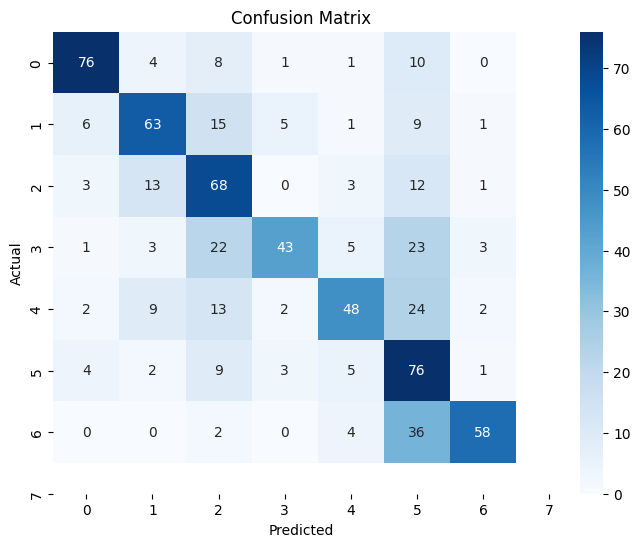


✅ Done: results.csv, metrics.txt, confusion_matrix.png generated.


In [ ]:
# --- Step 1: Load Data ---
df = pd.read_csv("features_df.csv")

# Create dummy filename column: img_0.jpg, img_1.jpg, ...
df['filename'] = [f"img_{i}.jpg" for i in range(len(df))]

# --- Step 2: Run Predictions ---
predictions = []
for _, row in df.iterrows():
    pred = decision_tree_classifier(
        row['corner_count'],
        row['extent'],
        row['circularity'],
        row['avg_hue'],
        row['aspect_ratio']
    )
    predictions.append(pred)

df['predicted'] = predictions
df['correct'] = df['label'] == df['predicted']

# --- Step 3: Save results.csv ---
df_out = df[['filename', 'label', 'predicted', 'correct']].rename(columns={'label': 'ground_truth'})
df_out.to_csv("results.csv", index=False)

# --- Step 4: Generate metrics.txt and print them ---
y_true = df['label']
y_pred = df['predicted']

overall_accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

with open("metrics.txt", "w") as f:
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}\n")
    f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n\n")
    
    for cls in sorted(df['label'].unique()):
        cls_str = str(cls)
        precision = report[cls_str]['precision']
        recall = report[cls_str]['recall']
        accuracy = (df[(df['label'] == cls) & (df['predicted'] == cls)].shape[0]) / (df[df['label'] == cls].shape[0])
        
        print(f"Class {cls}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  Accuracy:  {accuracy:.4f}\n")
        
        f.write(f"Class {cls}:\n")
        f.write(f"  Precision: {precision:.4f}\n")
        f.write(f"  Recall:    {recall:.4f}\n")
        f.write(f"  Accuracy:  {accuracy:.4f}\n\n")

# --- Step 5: Confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=sorted(df['label'].unique()))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()
plt.close()

print("\n✅ Done: results.csv, metrics.txt, confusion_matrix.png generated.")
